# Dino Game Modified
### James Saslow
### 10/21/2024


In [ ]:
import pygame
import sys
import random
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.basic_provider import BasicSimulator

# Quantum Error Corrected $R_{y}$ Gate

In [2]:
def error_corrected_Ry(theta):

    # ===============================================
    # Initializing Registers & Quantum Circuit

    q_logical  =  QuantumRegister(3, name = 'q')
    q_anc      =  QuantumRegister(2, name = 'anc')
    c_logical  = ClassicalRegister(3, name = 'c_logical')
    c_anc      = ClassicalRegister(2, name = 'c_anc')

    qc         =  QuantumCircuit(q_logical, q_anc,c_logical,c_anc,name = 'qc')

    # ===============================================
    # Prototyping Quantum Circuit

    # Performing the single qubit gate on the logical qubit 
    for i in range(3):
        qc.ry(theta,q_logical[i])

    # Sending information to ancillas
    qc.cx(q_logical[0], q_anc[0])
    qc.cx(q_logical[1], q_anc[0])

    qc.cx(q_logical[1], q_anc[1])
    qc.cx(q_logical[2], q_anc[1])

    qc.barrier()

    # Setting up ancilla measurement
    qc.measure(q_anc[0],c_anc[0])
    qc.measure(q_anc[1],c_anc[1])


    # Syndrome Operations (Check if these make sense!)
    qc.x(q_logical[2]).c_if(c_anc, 2) # X on q2 if ancilla measures |01>
    qc.x(q_logical[0]).c_if(c_anc, 1) # X on q0 if ancilla measures |10>
    qc.x(q_logical[1]).c_if(c_anc, 3) # X on q1 if ancilla measures |11>
    qc.barrier()

    # Measuring Logical Qubits
    for i in range(3):
        qc.measure(q_logical[i], c_logical[i])

    # ===============================================
    # Performing Single Shot Logical Qubit Measurement 

    backend = BasicSimulator()
    qc_rev = qc.reverse_bits() # Displaying results in big endian
    result = backend.run(qc_rev, shots=1).result()   
    counts = result.get_counts()          

    entire_state = list(counts.keys())[0]
    logical_state = entire_state[:3]

    # ===============================================
    #  Performing Majority Vote Majority Vote

    zero_count = 0
    one_count  = 0

    # Tallying Up the number of '0's and '1's in the logical qubit bitstring
    for x in logical_state:
        if x == '0':
            zero_count += 1
        elif x == '1':
            one_count +=1

    # Majority Vote wins
    if zero_count > one_count:
        state = '0'
    else:
        state = '1'
        
    return state

# Quantum Circuit Diagram

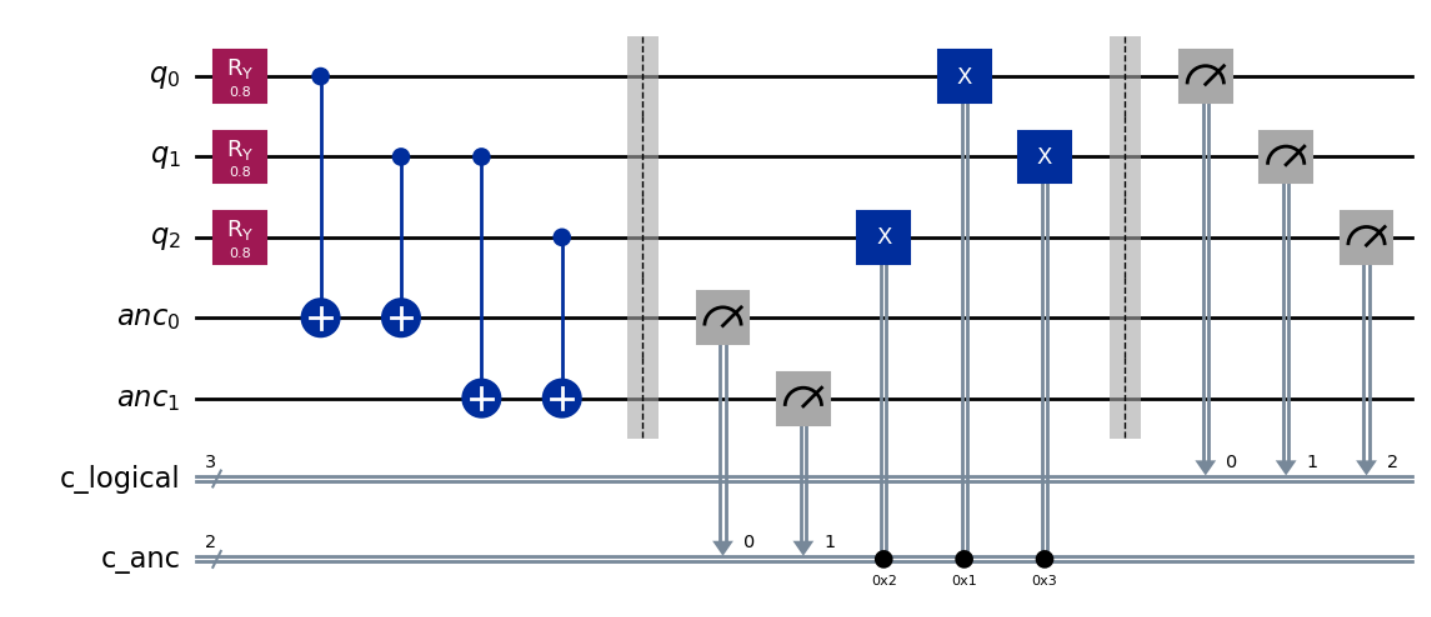

# Quantum Algorithm Plays Dino Game

In [ ]:

pygame.init()
screen = pygame.display.set_mode((1280, 720))
clock = pygame.time.Clock()
pygame.display.set_caption("Dino Game")

game_font = pygame.font.Font("assets/PressStart2P-Regular.ttf", 24)

# Classes


class Cloud(pygame.sprite.Sprite):
    def __init__(self, image, x_pos, y_pos):
        super().__init__()
        self.image = image
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))

    def update(self):
        self.rect.x -= 1


class Dino(pygame.sprite.Sprite):
    def __init__(self, x_pos, y_pos):
        super().__init__()
        self.running_sprites = []
        self.ducking_sprites = []

        self.running_sprites.append(pygame.transform.scale(
            pygame.image.load("assets/Dino1.png"), (80, 100)))
        self.running_sprites.append(pygame.transform.scale(
            pygame.image.load("assets/Dino2.png"), (80, 100)))

        self.ducking_sprites.append(pygame.transform.scale(
            pygame.image.load(f"assets/DinoDucking1.png"), (110, 60)))
        self.ducking_sprites.append(pygame.transform.scale(
            pygame.image.load(f"assets/DinoDucking2.png"), (110, 60)))

        self.x_pos = x_pos
        self.y_pos = y_pos
        self.current_image = 0
        self.image = self.running_sprites[self.current_image]
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))
        self.velocity = 50 # Default: 50
        self.gravity = 4.5 # Default: 4.5
        self.ducking = False

    def jump(self):
        jump_sfx.play()
        if self.rect.centery >= 360:
            while self.rect.centery - self.velocity > 50: # Default 40
                self.rect.centery -= 1

    def duck(self):
        self.ducking = True
        self.rect.centery = 380

    def unduck(self):
        self.ducking = False
        self.rect.centery = 360

    def apply_gravity(self):
        if self.rect.centery <= 360:
            self.rect.centery += self.gravity

    def update(self):
        self.animate()
        self.apply_gravity()

    def animate(self):
        self.current_image += 0.05
        if self.current_image >= 2:
            self.current_image = 0

        if self.ducking:
            self.image = self.ducking_sprites[int(self.current_image)]
        else:
            self.image = self.running_sprites[int(self.current_image)]


class Cactus(pygame.sprite.Sprite):
    def __init__(self, x_pos, y_pos):
        super().__init__()
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.sprites = []
        for i in range(1, 7):
            current_sprite = pygame.transform.scale(
                pygame.image.load(f"assets/cacti/cactus{i}.png"), (100, 100))
            self.sprites.append(current_sprite)
        self.image = random.choice(self.sprites)
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))

    def update(self):
        self.x_pos -= game_speed
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))

    def get_position(self):
        '''
        Custom Function from James
        '''
        distance = self.x_pos
        return distance


class Ptero(pygame.sprite.Sprite):
    def __init__(self):
        super().__init__()
        self.x_pos = 1300
        self.y_pos = random.choice([280, 295, 350])
        self.sprites = []
        self.sprites.append(
            pygame.transform.scale(
                pygame.image.load("assets/Ptero1.png"), (84, 62)))
        self.sprites.append(
            pygame.transform.scale(
                pygame.image.load("assets/Ptero2.png"), (84, 62)))
        self.current_image = 0
        self.image = self.sprites[self.current_image]
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))

    def update(self):
        self.animate()
        self.x_pos -= game_speed
        self.rect = self.image.get_rect(center=(self.x_pos, self.y_pos))

    def animate(self):
        self.current_image += 0.025
        if self.current_image >= 2:
            self.current_image = 0
        self.image = self.sprites[int(self.current_image)]

# Variables
game_speed = 9 #5 # Default: 5
jump_count = 10
player_score = 0
game_over = False
obstacle_timer = 0
obstacle_spawn = False
obstacle_cooldown = 2000 # Default 1000

# Surfaces
ground = pygame.image.load("assets/ground.png")
ground = pygame.transform.scale(ground, (1280, 20))
ground_x = 0
ground_rect = ground.get_rect(center=(640, 400))
cloud = pygame.image.load("assets/cloud.png")
cloud = pygame.transform.scale(cloud, (200, 80))

# Groups
cloud_group = pygame.sprite.Group()
obstacle_group = pygame.sprite.Group()
dino_group = pygame.sprite.GroupSingle()
ptero_group = pygame.sprite.Group()

# Objects
dinosaur = Dino(50, 360)
dino_group.add(dinosaur)

# Sounds
death_sfx = pygame.mixer.Sound("assets/sfx/lose.mp3")
points_sfx = pygame.mixer.Sound("assets/sfx/100points.mp3")
jump_sfx = pygame.mixer.Sound("assets/sfx/jump.mp3")

# Events
CLOUD_EVENT = pygame.USEREVENT
pygame.time.set_timer(CLOUD_EVENT, 3000)

# Functions


def end_game():
    global player_score, game_speed
    game_over_text = game_font.render("Game Over!", True, "black")
    game_over_rect = game_over_text.get_rect(center=(640, 300))
    score_text = game_font.render(f"Score: {int(player_score)}", True, "black")
    score_rect = score_text.get_rect(center=(640, 340))
    screen.blit(game_over_text, game_over_rect)
    screen.blit(score_text, score_rect)
    game_speed = game_speed # Default: 5
    cloud_group.empty()
    obstacle_group.empty()
    # pygame.time.wait(2000)  # Wait for 2 seconds to display the game over message
    # pygame.quit()
    # sys.exit()  # Safely exit after the game ends




while True:

    # =======================================================================================================
    # Distance code generated by ChatGPT
    
    # Find the distance to the nearest cactus
    if obstacle_group:
        dino_x_pos = dinosaur.rect.centerx  # Dinosaur's X position
        nearest_distance = float('inf')  # Set an initially high value for comparison
        for obstacle in obstacle_group:
            if isinstance(obstacle, Cactus):  # Check if the obstacle is a cactus
                obstacle_x_pos = obstacle.rect.centerx  # Cactus's X position
                distance_to_obstacle = obstacle_x_pos - dino_x_pos  # Calculate the distance
                if 0 < distance_to_obstacle < nearest_distance:  # Only consider obstacles ahead of the dinosaur
                    nearest_distance = distance_to_obstacle  # Update the nearest distance
        
        distance = nearest_distance if nearest_distance != float('inf') else None  # If no valid obstacle, set None
        # print(distance)
    # =======================================================================================================
    # Extracting instructions based on quantum probabilities



        if type(distance) != int:
            distance = 10**10


        Lambda = 100 # Free parameter
        b = 0.1 # Free Parameter
        max_distance = 1230

        x = distance/max_distance # Normalized Distance
        theta = np.arctan(Lambda*(x-b)) + np.pi/2
        outcome = error_corrected_Ry(theta) # |0> = |jump> and |1> = |wait>

        print(distance, outcome)

        # print(distance, net_action)

        # =======================================================================================================
        # Performing the action
        if not game_over:    
            if outcome == '0':
                dinosaur.jump()
            else:
                pass


    keys = pygame.key.get_pressed()
    if keys[pygame.K_DOWN]:
        dinosaur.duck()
    else:
        if dinosaur.ducking:
            dinosaur.unduck()
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
        if event.type == CLOUD_EVENT:
            current_cloud_y = random.randint(50, 300)
            current_cloud = Cloud(cloud, 1380, current_cloud_y)
            cloud_group.add(current_cloud)
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_SPACE or event.key == pygame.K_UP:
                dinosaur.jump()
                if game_over:
                    game_over = False
                    game_speed = game_speed # Default: 5
                    player_score = 0

    screen.fill("white")

    # Collisions
    if pygame.sprite.spritecollide(dino_group.sprite, obstacle_group, False):
        game_over = True
        death_sfx.play()
    if game_over:
        end_game()

    if not game_over:
        game_speed += 0.0025 #Commenting out Variable Game Speed to keep 'd' as our only variable input
        # In a later version, I will uncomment this and make another variable for d_dot that the QNN can train on
        if round(player_score, 1) % 100 == 0 and int(player_score) > 0:
            points_sfx.play()

        if pygame.time.get_ticks() - obstacle_timer >= obstacle_cooldown:
            obstacle_spawn = True

        if obstacle_spawn:
            obstacle_random = random.randint(1, 50)
            if obstacle_random in range(1, 7):
                new_obstacle = Cactus(1280, 340)
                obstacle_group.add(new_obstacle)
                obstacle_timer = pygame.time.get_ticks()
                obstacle_spawn = False
            # elif obstacle_random in range(7, 10): # Commenting out the pterodactyl code for now 
            #     new_obstacle = Ptero()
            #     obstacle_group.add(new_obstacle)
            #     obstacle_timer = pygame.time.get_ticks()
            #     obstacle_spawn = False


        player_score += 0.1
        player_score_surface = game_font.render(
            str(int(player_score)), True, ("black"))
        screen.blit(player_score_surface, (1150, 10))

        
        # =======================================================================================================
        # Distance code generated by ChatGPT

        # Find the distance to the nearest cactus
        if obstacle_group:
            dino_x_pos = dinosaur.rect.centerx  # Dinosaur's X position
            nearest_distance = float('inf')  # Set an initially high value for comparison
            for obstacle in obstacle_group:
                if isinstance(obstacle, Cactus):  # Check if the obstacle is a cactus
                    obstacle_x_pos = obstacle.rect.centerx  # Cactus's X position
                    distance_to_obstacle = obstacle_x_pos - dino_x_pos  # Calculate the distance
                    if 0 < distance_to_obstacle < nearest_distance:  # Only consider obstacles ahead of the dinosaur
                        nearest_distance = distance_to_obstacle  # Update the nearest distance
            
            distance = nearest_distance if nearest_distance != float('inf') else None  # If no valid obstacle, set None

            # Display the distance on the screen for debugging purposes
            if distance:
                distance_surface = game_font.render(f"Distance: {int(distance)}", True, ("black"))
                screen.blit(distance_surface, (800, 10))
        # =======================================================================================================


        cloud_group.update()
        cloud_group.draw(screen)

        ptero_group.update()
        ptero_group.draw(screen)

        dino_group.update()
        dino_group.draw(screen)

        obstacle_group.update()
        obstacle_group.draw(screen)

        ground_x -= game_speed

        screen.blit(ground, (ground_x, 360))
        screen.blit(ground, (ground_x + 1280, 360))

        if ground_x <= -1280:
            ground_x = 0

    clock.tick(60) # Default 120
    pygame.display.update()
